#### iLQR for point mass example with obstacle

In [3]:
import sys

In [4]:
sys.path.append('../')

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from ocp import *
from costs import *
from ocp_utils import *

%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4, suppress=True)

## Steps:

#### 1. Define the dynamical system (e.g., double integrator, 2d robot, n-d manipulator, etc.)
#### 2. Define the cost functions
#### 3. Construct the ILQR problem
#### 4. Solve

#### Create point mass system with dimension 2 (double integrator)

In [6]:
dt = 0.05  #duration of 1 time step
T = 100    #total number of time steps
Dx, Du = 4, 2 #dimensions of x and u

#Define the matrix A and B to define a double integrator
A = np.eye(Dx)
A[:2,2:] = np.eye(2)*dt
B = np.zeros((Dx, Du))
B[2:, :] = np.eye(Du)

sys = LinearSystem(A, B)

#### Set initial state and control trajectory

In [7]:
x0 = np.zeros(Dx)
sys.set_init_state(x0)

#set initial control output to be all zeros
us = np.zeros((T+1,sys.Du))
_ = sys.compute_matrices(x0, us[0])
xs = sys.rollout(us[:-1])

#### Plot initial trajectory

#### Set the regularization cost coefficients Q and R 

In [72]:
Q = np.eye(sys.Dx)*0.00  #coefficient for running cost
Qf = np.eye(sys.Dx)*10  #coefficient for terminal cost
R = np.eye(sys.Du)*0.005  #control coefficient
mu = 1e-6              #regularization coefficient

#### Set reference target

In [73]:
x_target = np.array([2, 2, 0,0])

#### Set obstacle

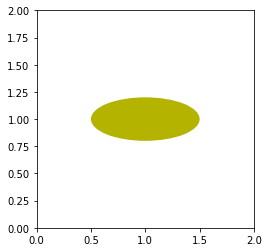

In [74]:
p_obs1 = np.array([1.,1.])   #obstacle position
r_obs1 = np.array([0.5, 0.2]) #radius of the ellipse
ori_obs1 = 0  #rotate the ellipse clockwise
w_obs1 = 1   #weight of the obstacle cost

#compute the covariance matrix of the ellipse
Sigma_obs1 = compute_covariance(r_obs1, ori_obs1)


#plot the ellipse
fig, ax = plt.subplots()
plot_gaussian_2D(p_obs1, Sigma_obs1, ax=ax)
ax.set_xlim(0, 2)
ax.set_ylim(0,2)
ax.set_aspect('equal')

### iLQR using cost model

#### Define the cost

In [75]:
#The costs consist of: a) state tracking (Q), b) control regularization (R), c) obstacle cost
#Running cost is for the time 0 <= t < T, while terminal cost is for the time t = T
costs = []
for i in range(T):
    runningStateCost = CostModelQuadratic(sys, Q, x_ref = x_target)
    runningControlCost = CostModelQuadratic(sys, None, R)
    runningObstacleCost = CostModelCollisionEllipsoid(sys, p_obs1, Sigma_obs1, w_obs1)    
    runningCost = CostModelSum(sys, [runningStateCost, runningControlCost, runningObstacleCost])
    costs += [runningCost]

terminalStateCost = CostModelQuadratic(sys,Qf, x_ref = x_target)
terminalControlCost = CostModelQuadratic(sys, None,R)
terminalObstacleCost = CostModelCollisionEllipsoid(sys, p_obs1, Sigma_obs1, w_obs1)
terminalCost = CostModelSum(sys, [terminalStateCost, terminalControlCost, terminalObstacleCost])

costs += [terminalCost]

#### Construct ILQR

In [76]:
ilqr_cost = ILQR(sys, mu)
ilqr_cost.set_init_state(x0)
ilqr_cost.set_timestep(T)
ilqr_cost.set_cost(costs)
ilqr_cost.set_state(xs, us)    #set initial guess

#### Solve and Plot

In [77]:
n_iter = 10
ilqr_cost.solve(n_iter, method='recursive')
xs_batch, us_batch = ilqr_cost.xs, ilqr_cost.us
#clear_output()

Cost converges at iteration 9, cannot decrease further


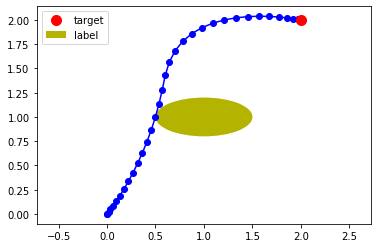

In [79]:
skip = 3
fig, ax = plt.subplots()
ax.plot(xs_batch[::skip,0], xs_batch[::skip,1], 'b-o')
ax.plot(x_target[0], x_target[1], 'or', markersize = 10, label='target')
plot_gaussian_2D(p_obs1, Sigma_obs1, ax=ax)
ax.legend()
plt.axis('equal')
plt.show()